In [15]:
import datetime

import pandas as pd
import pandas_profiling as pdp
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import lightgbm as lgb
import optuna.integration.lightgbm as lgb_opt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

In [16]:
# データロード
train_2018_df = pd.read_csv('../data/input/train_2018.csv')
train_2017_df = pd.read_csv('../data/input/train_2017.csv')
train_2016_df = pd.read_csv('../data/input/train_2016.csv')
train_2018_df['year'] = 2018
train_2017_df['year'] = 2017
train_2016_df['year'] = 2016

test_df = pd.read_csv('../data/input/test.csv')
test_df['year'] = 2019

In [17]:
# 教師データとテストデータのunion
all_df = pd.concat([train_2016_df, train_2017_df, train_2018_df, test_df], axis = 0).reset_index(drop=True)

### 特徴量エンジニアリング

In [18]:
# データ概要
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1902 non-null   int64  
 1   team                 1902 non-null   object 
 2   No                   1902 non-null   float64
 3   name                 1902 non-null   object 
 4   time_played          1414 non-null   float64
 5   position             1902 non-null   object 
 6   birthdate            1902 non-null   object 
 7   height               1902 non-null   float64
 8   weight               1902 non-null   float64
 9   salary               1902 non-null   object 
 10  nth_year             1902 non-null   float64
 11  is_youth             341 non-null    float64
 12  nationality          276 non-null    object 
 13  j1_total_num_played  1640 non-null   float64
 14  j1_total_scores      1554 non-null   float64
 15  j2_total_num_played  1134 non-null   f

In [19]:
# is_youthのboolean変換
all_df['is_youth'] = all_df['is_youth'].notnull()

In [20]:
# nationalityのNaN→Japan補完
all_df['nationality'] = all_df['nationality'].fillna('japan')

In [21]:
# team, name, position, nationalityのLabelEncoding
le = LabelEncoder()

for col in ['team', 'name', 'position', 'nationality']:
    le = le.fit(all_df[col])
    all_df[col] = le.transform(all_df[col])

In [22]:
# birthdateの年抽出
all_df['birthdate'] = pd.to_datetime(all_df['birthdate'])
all_df['birthdate_year'] = all_df['birthdate'].dt.year

In [23]:
# salaryのNaN→中央値補完
med_salary = all_df[all_df['salary'] != '-']['salary'].median()
all_df['salary'] = all_df['salary'].mask(all_df['salary'] == '-', med_salary)
all_df['salary'] = all_df['salary'].astype(float)

### 学習

In [24]:
# 教師, 検証データ
x_train_valid_df = all_df[all_df['year'] < 2019]
y_train_valid_df = x_train_valid_df['time_played']

# バリデーション
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid_df, y_train_valid_df, test_size=0.33, random_state=0, stratify = x_train_valid_df['year'])

# テストデータ
test = all_df[all_df['year'] == 2019]

In [25]:
# 入力する特徴量
features = [
    'team',
    'position',
    'height',
    'weight',
    'salary',
    'nth_year',
    'is_youth',
    'nationality',
    'birthdate_year',
    'year',
    'j1_total_num_played',
    'j1_total_scores',
    'j2_total_num_played',
    'j2_total_scores',
    'j3_total_num_played',
    'j3_total_scores',
    'na_total_num_played',
    'na_total_scores'
]

In [26]:
# カテゴリ変数
categorical_features = ['team', 'position', 'is_youth', 'nationality']

In [27]:
# lightgbmパラメータ
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_seed' : 0
}

In [28]:
# lightGBM用のデータセットを作成
lgb_train = lgb_opt.Dataset(x_train[features], y_train, categorical_feature = categorical_features, free_raw_data=False)
lgb_eval = lgb_opt.Dataset(x_valid[features], y_valid, categorical_feature = categorical_features, free_raw_data=False)

# モデルの作成
evals_result = {}
best_params = {}
model = lgb_opt.train(params = lgb_params,
                      train_set = lgb_train,
                      valid_sets = [lgb_train, lgb_eval],
                      categorical_feature = categorical_features,
                      verbose_eval = 10,
                      num_boost_round = 1000,
                      early_stopping_rounds = 10
)

# ベストパラメータの出力
best_params = model.params
print('=====Params======')
for key, value in best_params.items():
    print("  {}: {}".format(key, value))

# モデル精度の表示
valid_pred = model.predict(x_valid[features])
model_score = np.sqrt(metrics.mean_squared_error(valid_pred, y_valid))
print('=====Val score======')
print('  Val rmse score is {model_score}.'.format(model_score = model_score))

# テストデータの予測
y_pred = model.predict(test[features])

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 767.929	valid_1's rmse: 884.248
[20]	training's rmse: 647.201	valid_1's rmse: 845.886
[30]	training's rmse: 566.252	valid_1's rmse: 830.388
[40]	training's rmse: 505.661	valid_1's rmse: 828.226
[50]	training's rmse: 453.91	valid_1's rmse: 829.462
Early stopping, best iteration is:
[42]	training's rmse: 494.25	valid_1's rmse: 828.071


feature_fraction, val_score: 828.070948:  14%|######1                                    | 1/7 [00:00<00:00,  8.14it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 766.617	valid_1's rmse: 883.301
[20]	training's rmse: 646.495	valid_1's rmse: 850.36
[30]	training's rmse: 562.178	valid_1's rmse: 842.091
[40]	training's rmse: 500.577	valid_1's rmse: 845.42
Early stopping, best iteration is:
[30]	training's rmse: 562.178	valid_1's rmse: 842.091


feature_fraction, val_score: 828.070948:  29%|############2                              | 2/7 [00:00<00:00,  8.14it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 819.331	valid_1's rmse: 907.831
[20]	training's rmse: 709.013	valid_1's rmse: 860.984
[30]	training's rmse: 639.147	valid_1's rmse: 845.061
[40]	training's rmse: 584.427	valid_1's rmse: 840.064
[50]	training's rmse: 537.792	valid_1's rmse: 837.62
[60]	training's rmse: 498.912	valid_1's rmse: 836.472
Early stopping, best iteration is:
[59]	training's rmse: 502.526	valid_1's rmse: 836.339


feature_fraction, val_score: 828.070948:  43%|##################4                        | 3/7 [00:00<00:00,  8.49it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 784.267	valid_1's rmse: 884.727
[20]	training's rmse: 676.337	valid_1's rmse: 847.955
[30]	training's rmse: 597.144	valid_1's rmse: 833.218
[40]	training's rmse: 537.585	valid_1's rmse: 827.654
Early stopping, best iteration is:
[37]	training's rmse: 554.564	valid_1's rmse: 825.892


feature_fraction, val_score: 825.892096:  57%|########################5                  | 4/7 [00:00<00:00,  8.49it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 793.763	valid_1's rmse: 889.893
[20]	training's rmse: 687.618	valid_1's rmse: 850.467
[30]	training's rmse: 613.258	valid_1's rmse: 839.82
[40]	training's rmse: 556.432	valid_1's rmse: 839.094
Early stopping, best iteration is:
[31]	training's rmse: 607.02	valid_1's rmse: 836.672


feature_fraction, val_score: 825.892096:  71%|##############################7            | 5/7 [00:00<00:00,  9.16it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 771.254	valid_1's rmse: 884.835
[20]	training's rmse: 650.977	valid_1's rmse: 849.018
[30]	training's rmse: 571.61	valid_1's rmse: 840.915
[40]	training's rmse: 512.623	valid_1's rmse: 838.834
Early stopping, best iteration is:
[39]	training's rmse: 518.378	valid_1's rmse: 838.202


feature_fraction, val_score: 825.892096:  86%|####################################8      | 6/7 [00:00<00:00,  9.29it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 777.46	valid_1's rmse: 883.487
[20]	training's rmse: 661.777	valid_1's rmse: 851.705
[30]	training's rmse: 580.906	valid_1's rmse: 840.095
[40]	training's rmse: 521.385	valid_1's rmse: 831.278
[50]	training's rmse: 474.821	valid_1's rmse: 831.134
Early stopping, best iteration is:
[44]	training's rmse: 500.761	valid_1's rmse: 829.526


num_leaves, val_score: 825.892096:   0%|                                                        | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 825.892096:   5%|##4                                             | 1/20 [00:00<00:03,  5.89it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 825.892096:  10%|####8                                           | 2/20 [00:00<00:03,  5.67it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 840.526	valid_1's rmse: 900.221
[20]	training's rmse: 768.502	valid_1's rmse: 863.343
[30]	training's rmse: 718.273	valid_1's rmse: 851.805
[40]	training's rmse: 676.092	valid_1's rmse: 844.869
[50]	training's rmse: 644.623	valid_1's rmse: 842.254
[60]	training's rmse: 617.492	valid_1's rmse: 838.159
[70]	training's rmse: 592.957	valid_1's rmse: 840.803
Early stopping, best iteration is:
[60]	training's rmse: 617.492	valid_1's rmse: 838.159


num_leaves, val_score: 825.892096:  15%|#######2                                        | 3/20 [00:00<00:02,  6.32it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 897.476	valid_1's rmse: 917.425
[20]	training's rmse: 850.376	valid_1's rmse: 884.34
[30]	training's rmse: 822.604	valid_1's rmse: 874.669
[40]	training's rmse: 799.254	valid_1's rmse: 863.708
[50]	training's rmse: 780.311	valid_1's rmse: 857.805
[60]	training's rmse: 762.537	valid_1's rmse: 851.792
[70]	training's rmse: 748.455	valid_1's rmse: 847.508
[80]	training's rmse: 735.68	valid_1's rmse: 844.529
[90]	training's rmse: 725.322	valid_1's rmse: 843.861
Early stopping, best iteration is:
[85]	training's rmse: 730.079	valid_1's rmse: 842.282


num_leaves, val_score: 825.892096:  20%|#########6                                      | 4/20 [00:00<00:02,  7.01it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 825.892096:  25%|############                                    | 5/20 [00:00<00:02,  6.03it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 825.892096:  30%|##############4                                 | 6/20 [00:01<00:02,  5.46it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 825.892096:  35%|################7                               | 7/20 [00:01<00:02,  5.35it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 825.892096:  40%|###################2                            | 8/20 [00:01<00:02,  5.39it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 825.892096:  45%|#####################6                          | 9/20 [00:01<00:02,  5.39it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 825.892096:  50%|#######################5                       | 10/20 [00:01<00:01,  5.46it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 825.892096:  55%|#########################8                     | 11/20 [00:01<00:01,  5.43it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 825.892096:  60%|############################2                  | 12/20 [00:02<00:01,  5.38it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 825.892096:  65%|##############################5                | 13/20 [00:02<00:01,  5.51it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 825.892096:  70%|################################9              | 14/20 [00:02<00:01,  5.36it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


num_leaves, val_score: 823.301886:  75%|###################################2           | 15/20 [00:02<00:00,  6.04it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 823.301886:  80%|#####################################6         | 16/20 [00:02<00:00,  5.86it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.868	valid_1's rmse: 882.544
[20]	training's rmse: 669.67	valid_1's rmse: 847.662
[30]	training's rmse: 589.817	valid_1's rmse: 839.277
[40]	training's rmse: 526.44	valid_1's rmse: 835.953
[50]	training's rmse: 473.333	valid_1's rmse: 834.5
[60]	training's rmse: 431.268	valid_1's rmse: 829.892
Early stopping, best iteration is:
[59]	training's rmse: 434.666	valid_1's rmse: 829.838


num_leaves, val_score: 823.301886:  85%|#######################################9       | 17/20 [00:03<00:00,  5.73it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


num_leaves, val_score: 823.301886:  90%|##########################################3    | 18/20 [00:03<00:00,  6.32it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 949.362	valid_1's rmse: 951.685
[20]	training's rmse: 924.359	valid_1's rmse: 928.941
[30]	training's rmse: 907.709	valid_1's rmse: 914.905
[40]	training's rmse: 896.106	valid_1's rmse: 906.545
[50]	training's rmse: 887.051	valid_1's rmse: 900.93
[60]	training's rmse: 879.581	valid_1's rmse: 895.998
[70]	training's rmse: 873.169	valid_1's rmse: 893.99
[80]	training's rmse: 867.652	valid_1's rmse: 890.364
[90]	training's rmse: 862.699	valid_1's rmse: 889.209
[100]	training's rmse: 858.341	valid_1's rmse: 887.911
[110]	training's rmse: 854.476	valid_1's rmse: 886.547
[120]	training's rmse: 850.914	valid_1's rmse: 885.148
[130]	training's rmse: 847.664	valid_1's rmse: 884.691
[140]	training's rmse: 844.698	valid_1's rmse: 882.701
[150]	training's rmse: 841.884	valid_1's rmse: 881.178
[160]	training's rmse: 839.238	valid_1's rmse: 880.804
[170]	training's rmse: 836.799	valid_1's rmse: 879.334
[180]	training'

num_leaves, val_score: 823.301886:  95%|############################################6  | 19/20 [00:03<00:00,  6.78it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 783.913	valid_1's rmse: 882.376
[20]	training's rmse: 681.647	valid_1's rmse: 844.773
[30]	training's rmse: 607.198	valid_1's rmse: 834.661
[40]	training's rmse: 547.308	valid_1's rmse: 835.255
Early stopping, best iteration is:
[36]	training's rmse: 572.331	valid_1's rmse: 833.213


bagging, val_score: 823.301886:   0%|                                                           | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 848.648	valid_1's rmse: 892.674
[20]	training's rmse: 777.046	valid_1's rmse: 862.978
[30]	training's rmse: 721.438	valid_1's rmse: 844.052
[40]	training's rmse: 678.498	valid_1's rmse: 835.797
Early stopping, best iteration is:
[35]	training's rmse: 697.898	valid_1's rmse: 834.755


bagging, val_score: 823.301886:  10%|#####1                                             | 1/10 [00:00<00:00,  9.44it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 786.804	valid_1's rmse: 887.673
[20]	training's rmse: 676.261	valid_1's rmse: 850.384
[30]	training's rmse: 602.716	valid_1's rmse: 842.751
[40]	training's rmse: 540.131	valid_1's rmse: 835.995
[50]	training's rmse: 494.125	valid_1's rmse: 831.518
[60]	training's rmse: 455.298	valid_1's rmse: 829.611
[70]	training's rmse: 418.933	valid_1's rmse: 830.495
Early stopping, best iteration is:
[64]	training's rmse: 439.82	valid_1's rmse: 827.643


bagging, val_score: 823.301886:  20%|##########2                                        | 2/10 [00:00<00:00,  8.09it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 780.173	valid_1's rmse: 890.004
[20]	training's rmse: 673.633	valid_1's rmse: 855.171
[30]	training's rmse: 592.42	valid_1's rmse: 843.048
[40]	training's rmse: 529.427	valid_1's rmse: 835.916
[50]	training's rmse: 478.965	valid_1's rmse: 836.978
Early stopping, best iteration is:
[42]	training's rmse: 519.197	valid_1's rmse: 835.133


bagging, val_score: 823.301886:  30%|###############3                                   | 3/10 [00:00<00:00,  7.47it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 872.924	valid_1's rmse: 921.908
[20]	training's rmse: 813.427	valid_1's rmse: 887.729
[30]	training's rmse: 763.417	valid_1's rmse: 870.839
[40]	training's rmse: 725.018	valid_1's rmse: 861.27
[50]	training's rmse: 693.434	valid_1's rmse: 859.195
Early stopping, best iteration is:
[46]	training's rmse: 704.441	valid_1's rmse: 856.976


bagging, val_score: 823.301886:  40%|####################4                              | 4/10 [00:00<00:00,  7.57it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 784.466	valid_1's rmse: 886.041
[20]	training's rmse: 673.552	valid_1's rmse: 848.836
[30]	training's rmse: 600.403	valid_1's rmse: 842.527
[40]	training's rmse: 538.363	valid_1's rmse: 836.886
[50]	training's rmse: 488.098	valid_1's rmse: 837.679
Early stopping, best iteration is:
[41]	training's rmse: 533.368	valid_1's rmse: 836.291


bagging, val_score: 823.301886:  50%|#########################5                         | 5/10 [00:00<00:00,  7.59it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 811.89	valid_1's rmse: 893.787
[20]	training's rmse: 713.435	valid_1's rmse: 856.065
[30]	training's rmse: 645.342	valid_1's rmse: 845.988
[40]	training's rmse: 590.879	valid_1's rmse: 838.415
[50]	training's rmse: 547.638	valid_1's rmse: 837.825
[60]	training's rmse: 506.639	valid_1's rmse: 836.823
Early stopping, best iteration is:
[55]	training's rmse: 524.844	valid_1's rmse: 834.642


bagging, val_score: 823.301886:  60%|##############################6                    | 6/10 [00:00<00:00,  7.24it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 808.427	valid_1's rmse: 894.419
[20]	training's rmse: 712.249	valid_1's rmse: 857.694
[30]	training's rmse: 643.796	valid_1's rmse: 846.317
[40]	training's rmse: 588.384	valid_1's rmse: 839.732
[50]	training's rmse: 540.301	valid_1's rmse: 842.918
Early stopping, best iteration is:
[42]	training's rmse: 577.748	valid_1's rmse: 838.084


bagging, val_score: 823.301886:  70%|###################################6               | 7/10 [00:00<00:00,  7.36it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 794.07	valid_1's rmse: 888.331
[20]	training's rmse: 693.53	valid_1's rmse: 856.92
[30]	training's rmse: 620.01	valid_1's rmse: 846.913
[40]	training's rmse: 559.169	valid_1's rmse: 841.936
[50]	training's rmse: 509.312	valid_1's rmse: 843.672
Early stopping, best iteration is:
[43]	training's rmse: 542.4	valid_1's rmse: 840.015


bagging, val_score: 823.301886:  80%|########################################8          | 8/10 [00:01<00:00,  7.41it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 833.782	valid_1's rmse: 907.328
[20]	training's rmse: 749.205	valid_1's rmse: 862.514
[30]	training's rmse: 693.176	valid_1's rmse: 855.913
[40]	training's rmse: 646.784	valid_1's rmse: 848.799
[50]	training's rmse: 611.979	valid_1's rmse: 853.367
Early stopping, best iteration is:
[40]	training's rmse: 646.784	valid_1's rmse: 848.799


bagging, val_score: 823.301886:  90%|#############################################9     | 9/10 [00:01<00:00,  7.51it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.057	valid_1's rmse: 879.868
[20]	training's rmse: 673.914	valid_1's rmse: 845.387
[30]	training's rmse: 595.042	valid_1's rmse: 836.183
[40]	training's rmse: 535.417	valid_1's rmse: 829.21
[50]	training's rmse: 484.009	valid_1's rmse: 831.033
Early stopping, best iteration is:
[43]	training's rmse: 518.887	valid_1's rmse: 827.969


feature_fraction_stage2, val_score: 823.301886:   0%|                                            | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 782.734	valid_1's rmse: 882.178
[20]	training's rmse: 675.919	valid_1's rmse: 847.126
[30]	training's rmse: 596.876	valid_1's rmse: 838.677
[40]	training's rmse: 538.164	valid_1's rmse: 825.459
[50]	training's rmse: 489.597	valid_1's rmse: 827.464
Early stopping, best iteration is:
[40]	training's rmse: 538.164	valid_1's rmse: 825.459


feature_fraction_stage2, val_score: 823.301886:  17%|######                              | 1/6 [00:00<00:00,  8.34it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


feature_fraction_stage2, val_score: 823.301886:  33%|############                        | 2/6 [00:00<00:00,  8.51it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


feature_fraction_stage2, val_score: 823.301886:  50%|##################                  | 3/6 [00:00<00:00,  8.61it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 791.283	valid_1's rmse: 888.768
[20]	training's rmse: 682.779	valid_1's rmse: 851.183
[30]	training's rmse: 608.124	valid_1's rmse: 838.42
[40]	training's rmse: 549.394	valid_1's rmse: 831.256
[50]	training's rmse: 499.882	valid_1's rmse: 829.13
[60]	training's rmse: 458.874	valid_1's rmse: 828.645
Early stopping, best iteration is:
[56]	training's rmse: 474.202	valid_1's rmse: 827.482


feature_fraction_stage2, val_score: 823.301886:  67%|########################            | 4/6 [00:00<00:00,  8.09it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 774.954	valid_1's rmse: 884.986
[20]	training's rmse: 661.853	valid_1's rmse: 846.887
[30]	training's rmse: 582.936	valid_1's rmse: 837.325
[40]	training's rmse: 519.426	valid_1's rmse: 832.178
[50]	training's rmse: 470.917	valid_1's rmse: 831.916
[60]	training's rmse: 428.597	valid_1's rmse: 830.604
[70]	training's rmse: 392.677	valid_1's rmse: 829.934
Early stopping, best iteration is:
[67]	training's rmse: 402.858	valid_1's rmse: 828.587


feature_fraction_stage2, val_score: 823.301886:  83%|##############################      | 5/6 [00:00<00:00,  7.39it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 774.954	valid_1's rmse: 884.986
[20]	training's rmse: 661.853	valid_1's rmse: 846.887
[30]	training's rmse: 582.936	valid_1's rmse: 837.325
[40]	training's rmse: 519.426	valid_1's rmse: 832.178
[50]	training's rmse: 470.917	valid_1's rmse: 831.916
[60]	training's rmse: 428.597	valid_1's rmse: 830.604
[70]	training's rmse: 392.677	valid_1's rmse: 829.934
Early stopping, best iteration is:
[67]	training's rmse: 402.858	valid_1's rmse: 828.587


regularization_factors, val_score: 823.301886:   0%|                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.972	valid_1's rmse: 883.061
[20]	training's rmse: 675.729	valid_1's rmse: 849.039
[30]	training's rmse: 595.599	valid_1's rmse: 839.213
[40]	training's rmse: 532.532	valid_1's rmse: 832.329
[50]	training's rmse: 484.662	valid_1's rmse: 834.404
Early stopping, best iteration is:
[42]	training's rmse: 521.454	valid_1's rmse: 831.565


regularization_factors, val_score: 823.301886:   5%|#8                                  | 1/20 [00:00<00:02,  8.20it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.998	valid_1's rmse: 884.838
[20]	training's rmse: 674.902	valid_1's rmse: 844.785
[30]	training's rmse: 598.473	valid_1's rmse: 828.477
[40]	training's rmse: 538.48	valid_1's rmse: 828.554
Early stopping, best iteration is:
[32]	training's rmse: 586.792	valid_1's rmse: 828.062


regularization_factors, val_score: 823.301886:  10%|###6                                | 2/20 [00:00<00:02,  8.65it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  15%|#####3                              | 3/20 [00:00<00:01,  8.51it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  20%|#######2                            | 4/20 [00:00<00:01,  8.35it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.877	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.556	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  25%|#########                           | 5/20 [00:00<00:01,  8.33it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.556	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  30%|##########7                         | 6/20 [00:00<00:01,  8.01it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 782.361	valid_1's rmse: 884.553
[20]	training's rmse: 674.033	valid_1's rmse: 848.604
[30]	training's rmse: 593.764	valid_1's rmse: 843.495
[40]	training's rmse: 530.762	valid_1's rmse: 838.088
[50]	training's rmse: 479.115	valid_1's rmse: 841.107
Early stopping, best iteration is:
[40]	training's rmse: 530.762	valid_1's rmse: 838.088


regularization_factors, val_score: 823.301886:  35%|############6                       | 7/20 [00:00<00:01,  7.82it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  40%|##############4                     | 8/20 [00:01<00:01,  7.49it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  45%|################2                   | 9/20 [00:01<00:01,  7.43it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  50%|#################5                 | 10/20 [00:01<00:01,  7.42it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  55%|###################2               | 11/20 [00:01<00:01,  7.21it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  60%|#####################              | 12/20 [00:01<00:01,  6.24it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.989	valid_1's rmse: 884.833
[20]	training's rmse: 674.886	valid_1's rmse: 844.781
[30]	training's rmse: 598.449	valid_1's rmse: 828.474
[40]	training's rmse: 535.987	valid_1's rmse: 824.651
[50]	training's rmse: 486.567	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.123	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  65%|######################7            | 13/20 [00:01<00:01,  6.40it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 810.815	valid_1's rmse: 893.293
[20]	training's rmse: 709.399	valid_1's rmse: 856.942
[30]	training's rmse: 635.067	valid_1's rmse: 838.483
[40]	training's rmse: 576.201	valid_1's rmse: 833.47
[50]	training's rmse: 524.09	valid_1's rmse: 828.72
[60]	training's rmse: 482.6	valid_1's rmse: 827.952
Early stopping, best iteration is:
[56]	training's rmse: 497.481	valid_1's rmse: 826.825


regularization_factors, val_score: 823.301886:  70%|########################5          | 14/20 [00:01<00:00,  6.12it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  75%|##########################2        | 15/20 [00:02<00:00,  6.29it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.556	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  80%|############################       | 16/20 [00:02<00:00,  6.45it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.985	valid_1's rmse: 884.831
[20]	training's rmse: 674.881	valid_1's rmse: 844.78
[30]	training's rmse: 598.444	valid_1's rmse: 828.474
[40]	training's rmse: 535.982	valid_1's rmse: 824.651
[50]	training's rmse: 486.561	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.118	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  85%|#############################7     | 17/20 [00:02<00:00,  6.66it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  90%|###############################5   | 18/20 [00:02<00:00,  6.39it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


regularization_factors, val_score: 823.301886:  95%|#################################2 | 19/20 [00:02<00:00,  6.59it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 781.981	valid_1's rmse: 884.829
[20]	training's rmse: 674.876	valid_1's rmse: 844.779
[30]	training's rmse: 598.439	valid_1's rmse: 828.473
[40]	training's rmse: 535.977	valid_1's rmse: 824.651
[50]	training's rmse: 486.555	valid_1's rmse: 826.975
Early stopping, best iteration is:
[45]	training's rmse: 510.112	valid_1's rmse: 823.302


min_data_in_leaf, val_score: 823.301886:   0%|                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 798.364	valid_1's rmse: 887.309
[20]	training's rmse: 702.808	valid_1's rmse: 853.918
[30]	training's rmse: 632.109	valid_1's rmse: 849.485
[40]	training's rmse: 574.336	valid_1's rmse: 839.859
[50]	training's rmse: 527.814	valid_1's rmse: 839.906
Early stopping, best iteration is:
[48]	training's rmse: 536.643	valid_1's rmse: 838.879


min_data_in_leaf, val_score: 823.301886:  20%|########6                                  | 1/5 [00:00<00:00,  6.50it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 742.984	valid_1's rmse: 892.702
[20]	training's rmse: 613.521	valid_1's rmse: 864.174
[30]	training's rmse: 521.901	valid_1's rmse: 857.465
[40]	training's rmse: 456.65	valid_1's rmse: 855.622
Early stopping, best iteration is:
[38]	training's rmse: 468.224	valid_1's rmse: 854.519


min_data_in_leaf, val_score: 823.301886:  40%|#################2                         | 2/5 [00:00<00:00,  6.32it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 756.1	valid_1's rmse: 881.18
[20]	training's rmse: 634.817	valid_1's rmse: 840.896
[30]	training's rmse: 546.346	valid_1's rmse: 831.016
[40]	training's rmse: 477.333	valid_1's rmse: 824.73
[50]	training's rmse: 425.84	valid_1's rmse: 826.437
Early stopping, best iteration is:
[48]	training's rmse: 435.936	valid_1's rmse: 824


min_data_in_leaf, val_score: 823.301886:  60%|#########################8                 | 3/5 [00:00<00:00,  6.46it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 893.302	valid_1's rmse: 909.96
[20]	training's rmse: 845.184	valid_1's rmse: 877.668
[30]	training's rmse: 816.106	valid_1's rmse: 864.302
[40]	training's rmse: 791.046	valid_1's rmse: 855.524
[50]	training's rmse: 772.41	valid_1's rmse: 855.19
[60]	training's rmse: 755.193	valid_1's rmse: 852.526
[70]	training's rmse: 740.167	valid_1's rmse: 852.847
Early stopping, best iteration is:
[60]	training's rmse: 755.193	valid_1's rmse: 852.526


min_data_in_leaf, val_score: 823.301886:  80%|##################################4        | 4/5 [00:00<00:00,  7.15it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 853.151	valid_1's rmse: 904.163
[20]	training's rmse: 788.249	valid_1's rmse: 866.936
[30]	training's rmse: 741.816	valid_1's rmse: 849.282
[40]	training's rmse: 704.2	valid_1's rmse: 845.056
[50]	training's rmse: 675.029	valid_1's rmse: 841.394
[60]	training's rmse: 647.113	valid_1's rmse: 834.282
[70]	training's rmse: 625.178	valid_1's rmse: 836.136
Early stopping, best iteration is:
[62]	training's rmse: 642.703	valid_1's rmse: 834.161


min_data_in_leaf, val_score: 823.301886: 100%|###########################################| 5/5 [00:00<00:00,  6.90it/s]


=====Params======
  objective: regression
  metric: rmse
  random_seed: 0
  lambda_l1: 0.0
  lambda_l2: 0.0
  num_leaves: 33
  feature_fraction: 0.6
  bagging_fraction: 1.0
  bagging_freq: 0
  min_child_samples: 20
=====Val score======
  Val rmse score is 823.3018860353397.


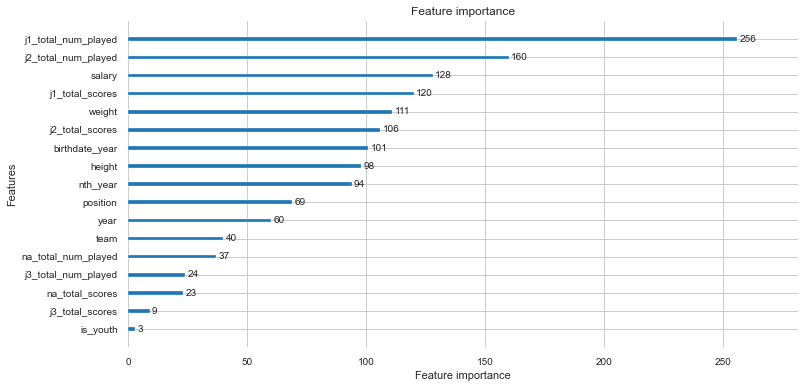

In [29]:
lgb.plot_importance(model, figsize=(12, 6))
plt.show()

### 出力

In [ ]:
# 提出用データの作成
sub = test[['id', 'time_played']].copy()
sub['time_played'] = y_pred

# csvの出力
now = datetime.datetime.now()
sub_name = '特徴量追加_total_num_played・total_scores'
file_name = '../data/output/sub_' + sub_name + '_' + now.strftime('%Y%m%d_%H%M%S') + '.csv'
sub.to_csv(file_name, index=False)